In [1]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

Definisco la seguente funzione per generare, in maniera casuale, i dati iniziali per GMRES:
- `A`: la matrice (sparsa) dei coefficienti del Sistema Lineare
- `b`: il vettore dei termini noti del Sistema Lineare
- `x0`: il guess iniziale

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

Implementazione di GMRES con l'iterazione di Arnoldi e il metodo dell'Ortogonalizzazione

In [42]:
function [x res] = mygmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k
        v = A*Q(:, j);  
        
        % ortogonalizzazione
        for _ = 1:2
            for i = 1:j
                tmp = Q(:,i)' * v;
                v = v - tmp * Q(:, i);
                H(i,j) += tmp;
            end
        end

        H(j+1, j) = norm(v, 2);
        
        % TODO: capire come gestire la divisone per 0
        if (H(j+1, j) == 0)
            error("Divisione per 0 !!");
        end
        
        Q(:, j+1) = v / H(j+1, j);

        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('🚀 Raggiunta Tolleranza, stop');
            figure();
            imagesc(H(1:j, 1:j));
            colorbar();
            title("Matrix H");
            return;
        end
    end
    
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    figure();
    imagesc(H);  % TODO: plottare meglio
    colorbar();
    title("Matrix H");
endfunction

## Test 1 - Random Matrix

Genero un Sistema Lineare e il guess in modo casuale per testare le perofrmance di GMRES.

In [43]:
[A, b, x0] = generateData(300, .5);

Mostro a video i dati ottenuti:
- le prime 50 righe e colonne della matrice dei coefficienti `A`,
- il vettore dei termini noti `b`,
- il guess iniziale `x0`

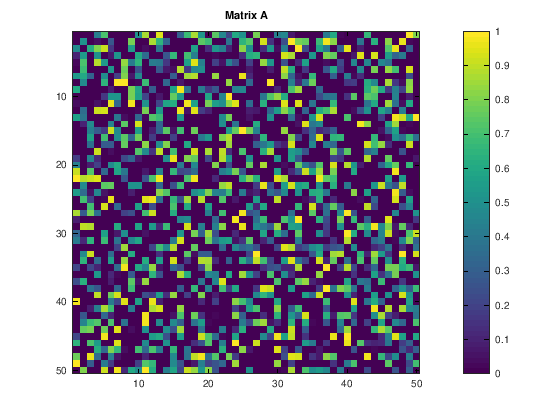

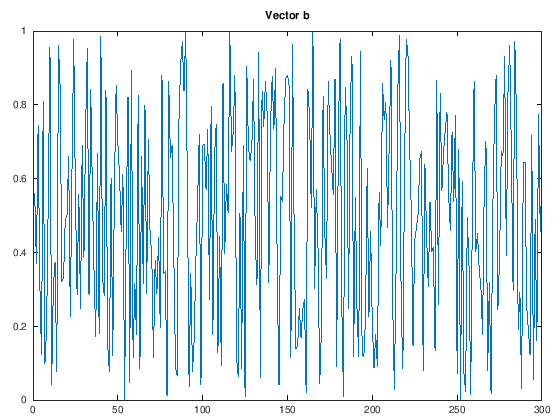

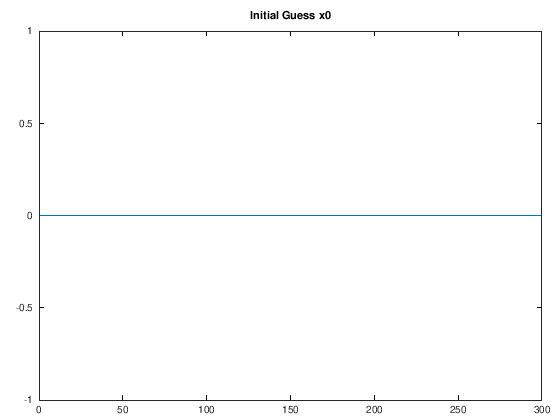

In [44]:
figure();
imagesc(A(1:50, 1:50));
colorbar();
title("Matrix A");

figure();
plot(b);
title("Vector b");

figure();
plot(x0);
title("Initial Guess x0");

Avvio l'esecuzione di GMRES con i dati precedentemente generati, impostando come numeoro di iterazioni 50 e tolleranza `1e-10`.

🐌 Raggiunto massimo numero di Iterazioni


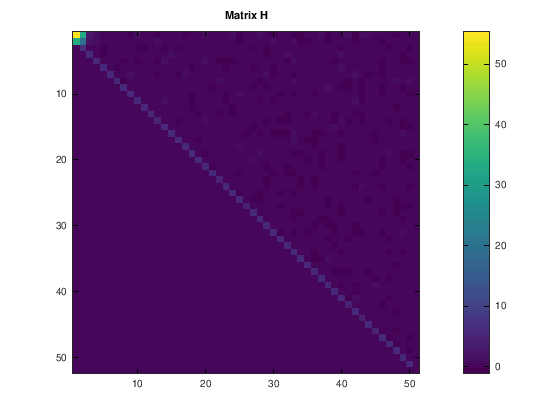

In [45]:
[x, res] = mygmres(A, b, x0, 50, 1e-10);

Mostro la soluzione `x` restituita da GMRES e la confronto con la reale soluzione al Sistema Lineare.

In [9]:
x
x_true = A\b
max(x_true-x)
approx_error = norm(x_true-x, 2)

x =

  -1.5988e-02
   1.9679e-02
   6.8196e-02
  -5.4277e-03
  -2.2284e-02
   8.8058e-03
  -1.0142e-02
   8.9331e-03
  -7.4107e-03
   1.0656e-02
  -2.9589e-02
   2.5662e-02
  -1.2659e-02
  -8.9614e-02
   4.6106e-03
  -9.4186e-03
  -1.3646e-02
  -3.3341e-02
   2.4914e-02
  -3.0541e-04
   1.5971e-02
   3.7384e-02
   1.2177e-02
   1.9394e-02
  -2.1301e-03
   1.9104e-03
  -1.3429e-02
   2.0210e-02
   1.3173e-02
   9.6206e-03
   2.3598e-02
  -3.5591e-03
  -2.1809e-02
   1.6008e-02
  -9.3330e-04
   2.5905e-02
   1.2094e-02
   3.0037e-02
  -9.7015e-03
   3.0653e-02
   1.3493e-02
   1.1854e-02
   9.7956e-03
   1.2715e-02
   3.7242e-02
  -1.6936e-02
   4.6700e-02
   2.8644e-02
   9.8020e-03
   1.6743e-02
   1.1461e-02
  -2.7865e-03
  -1.8973e-02
   1.0275e-02
   1.7969e-02
  -1.5836e-03
   1.5892e-02
   8.3726e-04
  -7.9172e-03
  -7.6164e-03
  -1.2929e-02
  -8.2796e-03
   1.6504e-02
  -1.9836e-02
   7.7715e-03
   1.4618e-02
   6.2747e-03
   4.3014e-03
   3.5323e-03
   2.5035e-02
  -1.2990e-02
 

Stampo l'andamento del residual all'avanzare delle iterazioni.

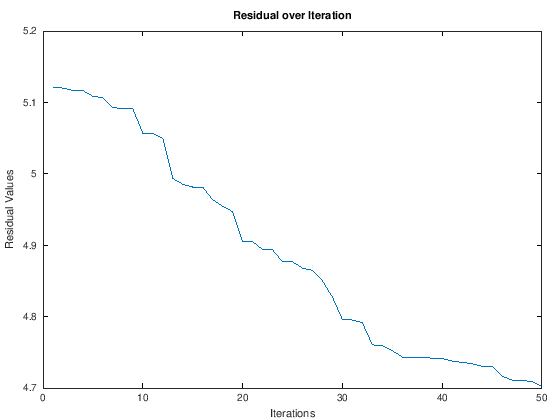

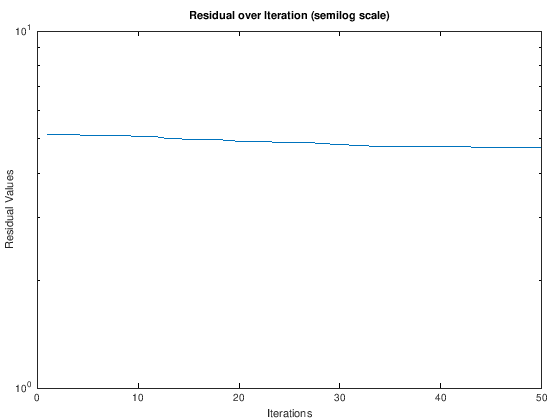

In [10]:
figure();
plot(res);
title("Residual over Iteration");
xlabel("Iterations");
ylabel("Residual Values");

figure();
semilogy(res);
title("Residual over Iteration (semilog scale)");
xlabel("Iterations");
ylabel("Residual Values");


Definisco ora una fuzione per stampare i valori dei Residuals.

In [11]:
function plotResiduals(res, all=false)
    if (all)
        figure();
        plot(res);
        title("Residual over Iteration");
        xlabel("Iterations");
        ylabel("Residual Values");
    end

    figure();
    semilogy(res);
    title("Residual over Iteration (semilog scale)");
    xlabel("Iterations");
    ylabel("Residual Values");

endfunction

Provo ad impostare come numero di iterazioni la dimensione della matrice e vedo come si comporta GMRES.

🚀 Raggiunta Tolleranza, stop
approx_error =  69.119


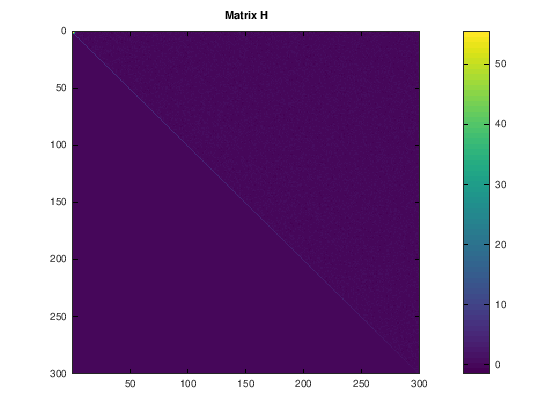

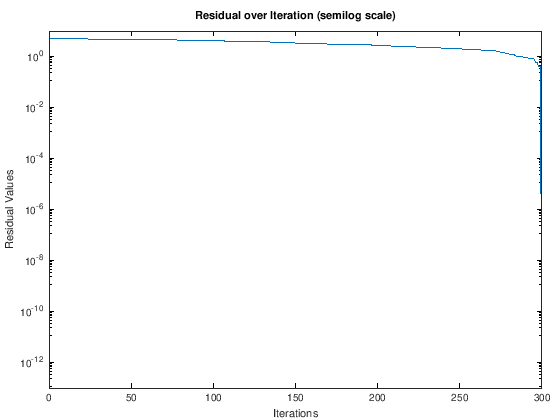

In [46]:
[x, res] = mygmres(A, b, x0, 300, 1e-10);
approx_error = norm(x_true-x, 2)

plotResiduals(res);

## Test 2 

Provo ad aumentare le dimensioni del sistema per vedere come performa GMRES con un input di medie dimensioni.

🐌 Raggiunto massimo numero di Iterazioni


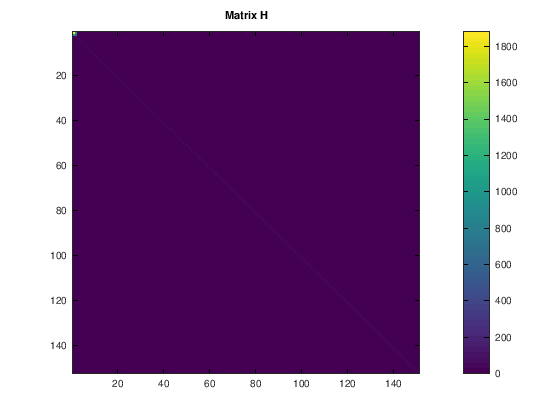

In [47]:
[A, b, x0] = generateData(10000, .5);
[x, res] = mygmres(A, b, x0, 150, 1e-10);

In [48]:
% x
x_true = A\b;
max(x_true-x)
approx_error = norm(x_true-x, 2)

ans =  1.5184
approx_error =  41.017


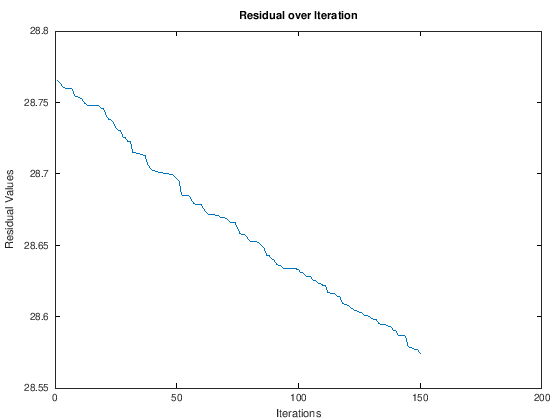

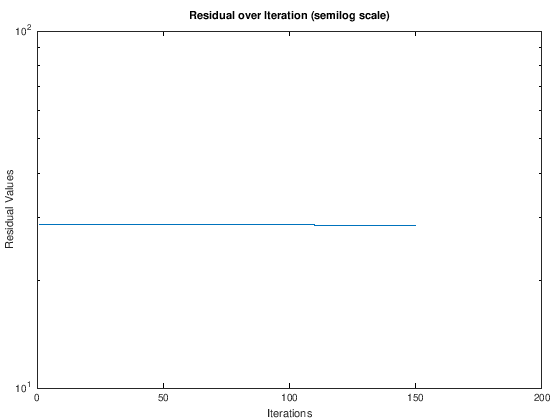

In [49]:
plotResiduals(res, all=true);

## Test 3

Analizzo le varie matrici che genero per capire quale proprietà hanno in comune.

La seguente funzione va a mostrare a video le prime 50 righe e colonne e gli eigenvalue della matrice passata in input.

In [50]:
function plotMatrix(A, figTitle="Matrix")
    figure();
    imagesc(A(1:50, 1:50));
    colorbar();
    title(figTitle);
endfunction

function plotEig(A, figTitle="Eigenvalues")
    figure();
    plot(eig(A), 'o');
    title(figTitle);
endfunction

function matrixInfo(A, title1="Matrix", title2="Eigenvalues")
    plotMatrix(A, title1);

    plotEig(A, title2);
endfunction

Genero 4 Sistemi Lineari differenti con dimensione compresa tra 50 e 800, per rendere il calcolo degli autovalori immediato.

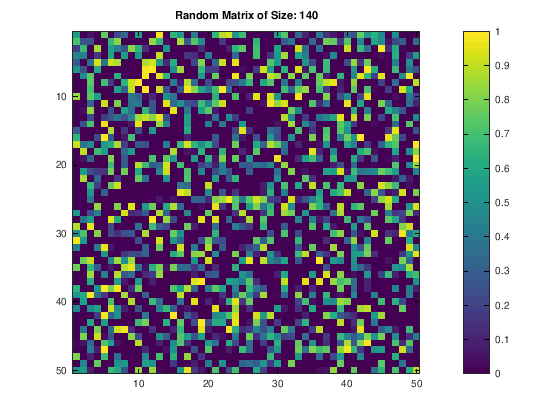

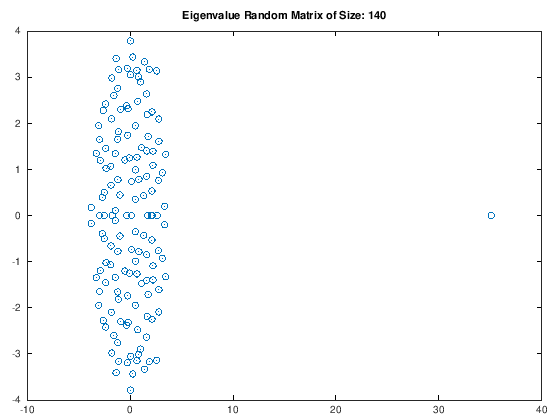

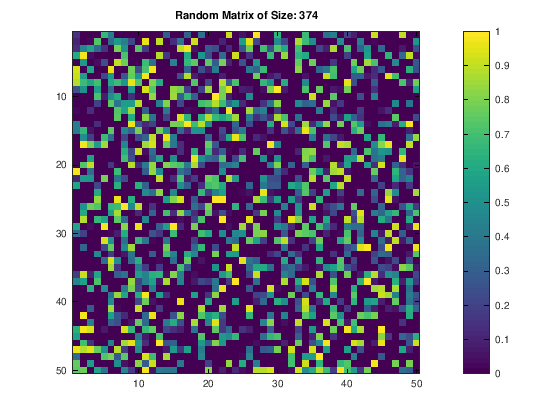

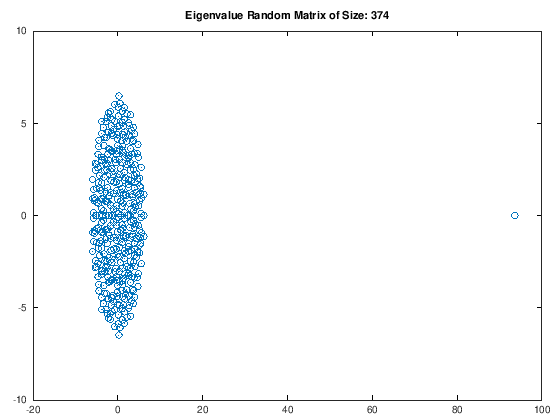

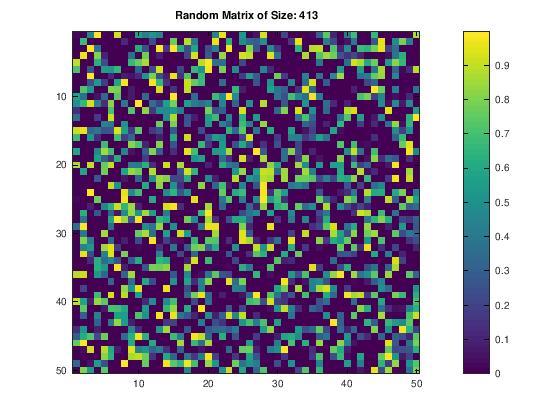

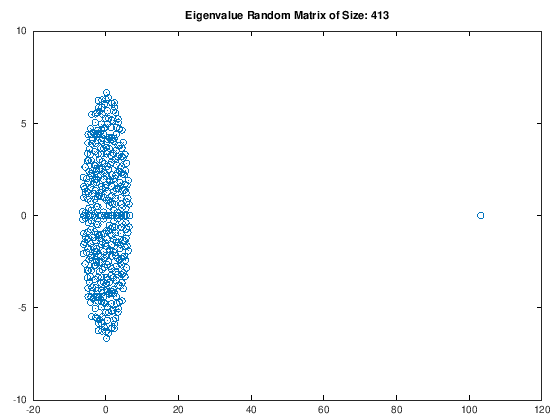

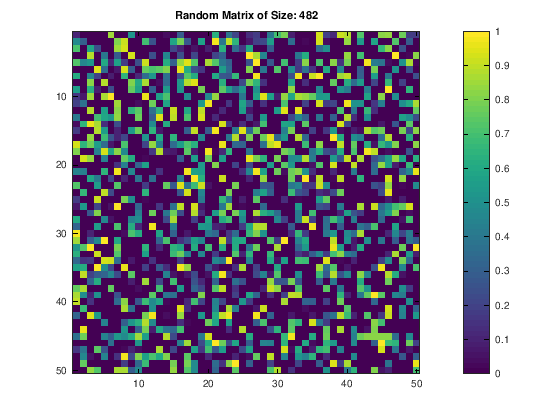

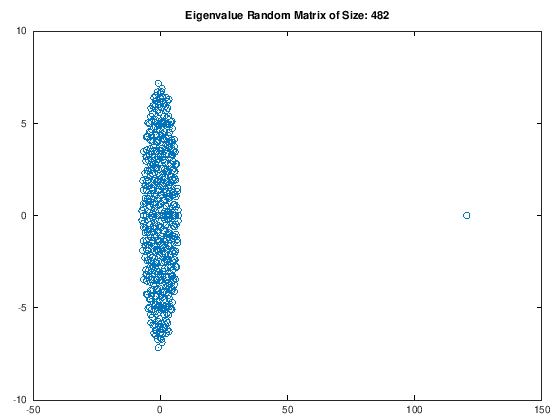

In [51]:
for _ = 1:4
    % 50 <= random size <= 800
    dim = randi([50 800], 1, 1);
    
    [A, b, x0] = generateData(dim, .5);
    
    matrixInfo(
        A, 
        title1=["Random Matrix of Size: " num2str(dim)], 
        title2=["Eigenvalue Random Matrix of Size: " num2str(dim)]
    );
end

## Test 4

Applico GMRES ad un Sistema Lineare la cui matrice dei coefficienti è l'identità.

error: Divisione per 0 !!
error: called from
    mygmres at line 29 column 13


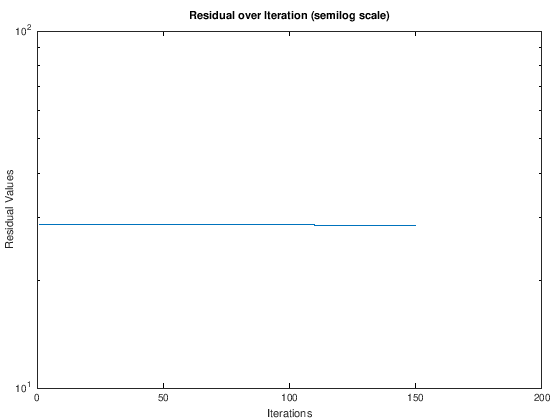

In [53]:
[A, b, x0] = generateData(300, .5);
A = eye(300);

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);

## Test 5

GMRES con multiplo della matrice identità

🚀 Raggiunta Tolleranza, stop


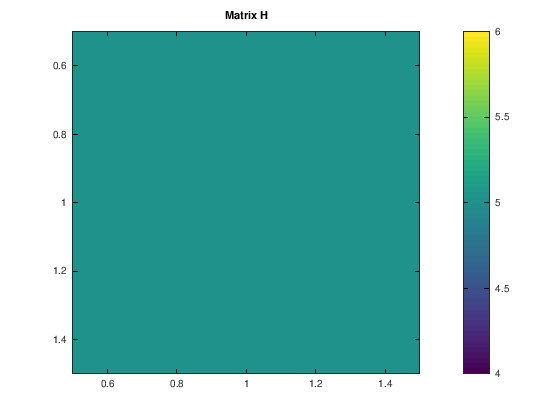

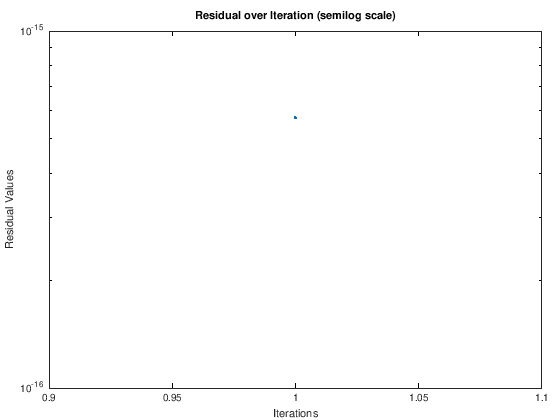

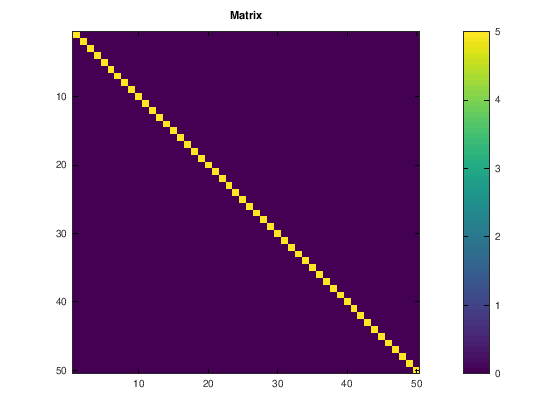

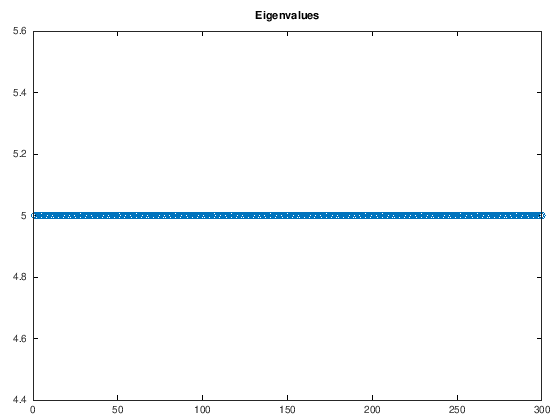

In [54]:
A = eye(300) * 5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

## Test 6

Matrice radom + multiplo identità

🐌 Raggiunto massimo numero di Iterazioni


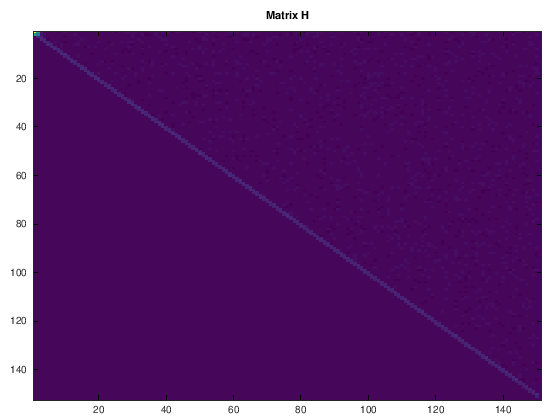

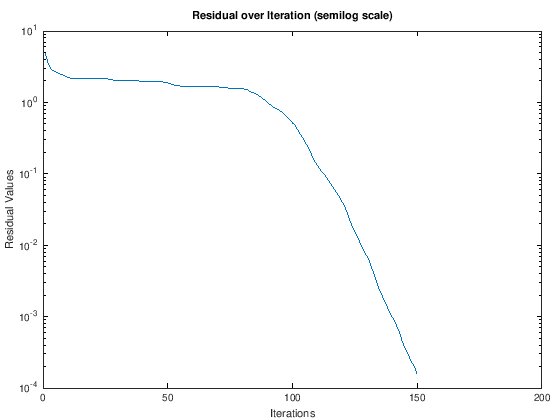

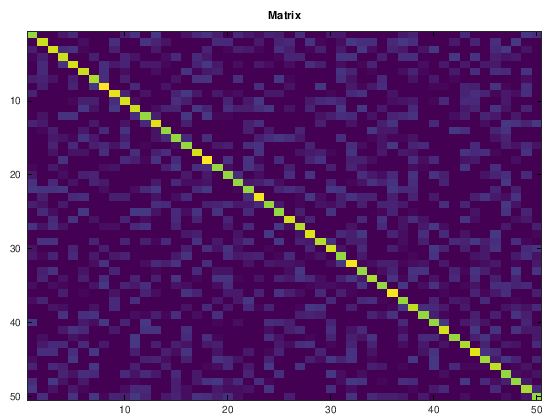

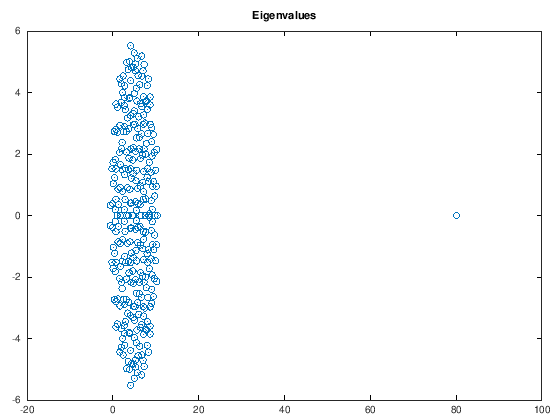

In [20]:
[A, b, x0] = generateData(300, .5);
A = A + eye(300)*5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

## Test 7

Multiplo Identità più una matrice con valori compresi tra 0 e 1

In [21]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

🚀 Raggiunta Tolleranza, stop
approx_error =    6.8220e-12
🚀 Raggiunta Tolleranza, stop
approx_error =    2.4250e-11
🐌 Raggiunto massimo numero di Iterazioni
approx_error =  518.14
🚀 Raggiunta Tolleranza, stop
approx_error =    2.3117e-11
🚀 Raggiunta Tolleranza, stop
approx_error =    7.2171e-12


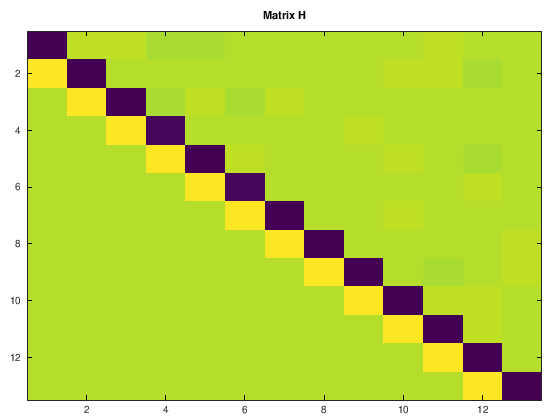

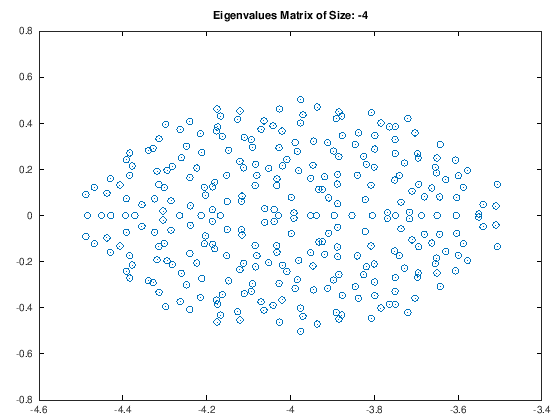

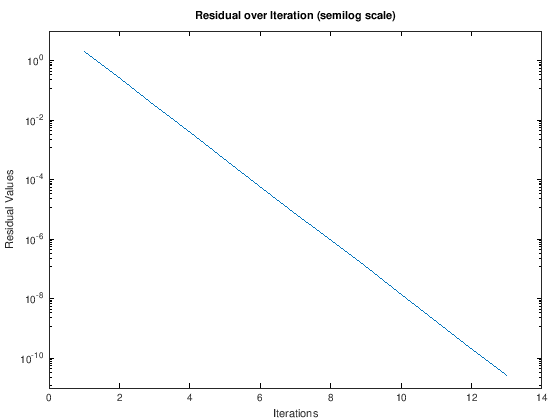

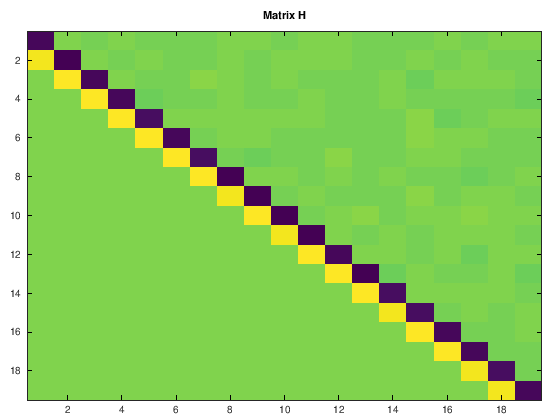

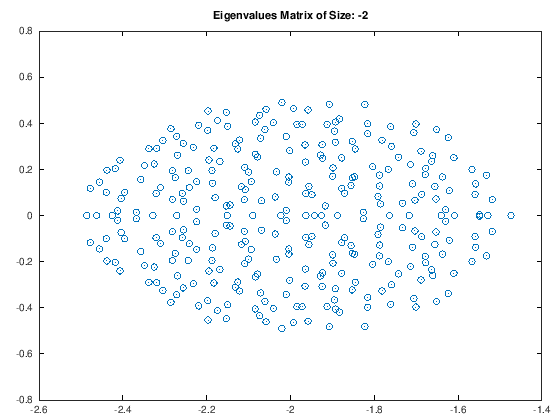

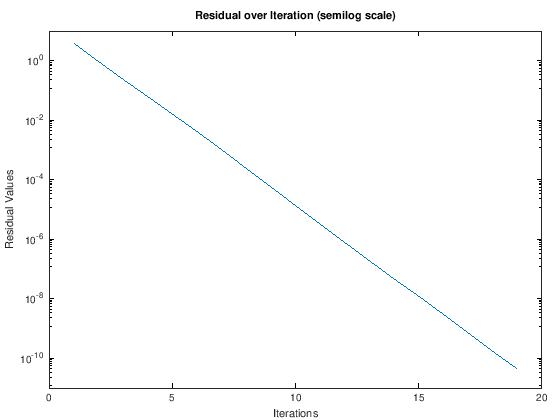

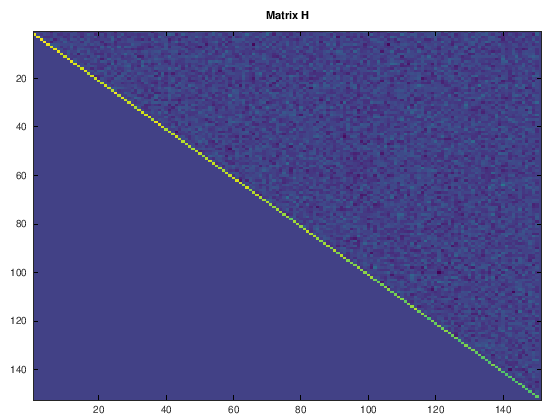

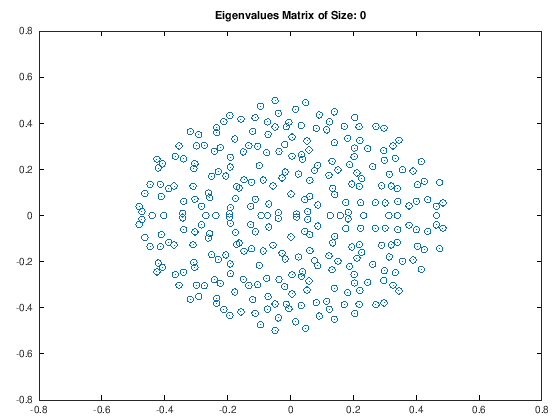

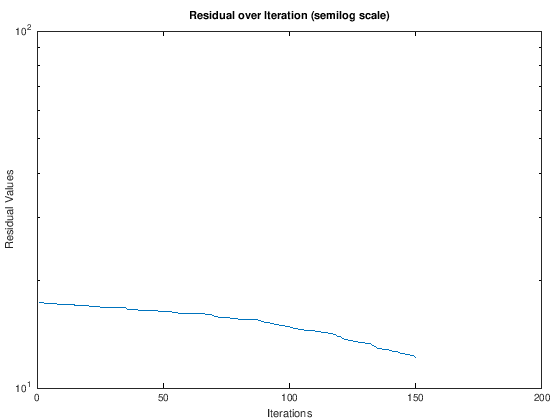

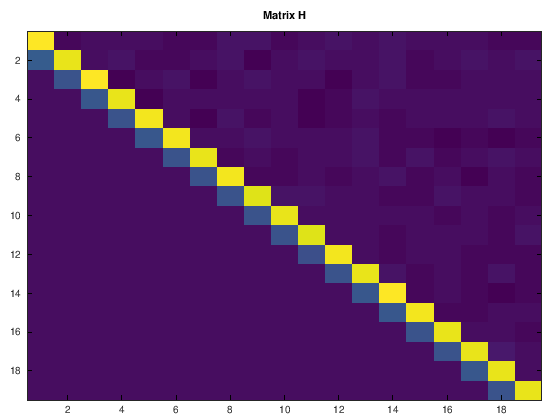

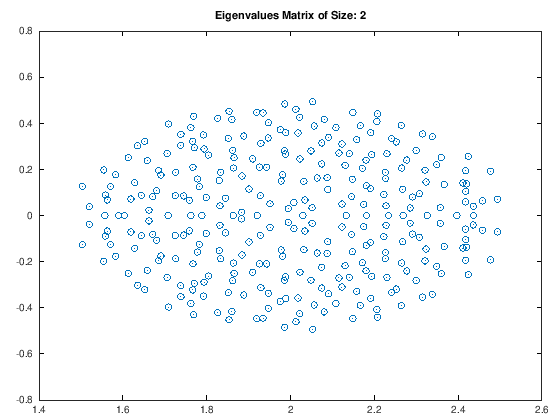

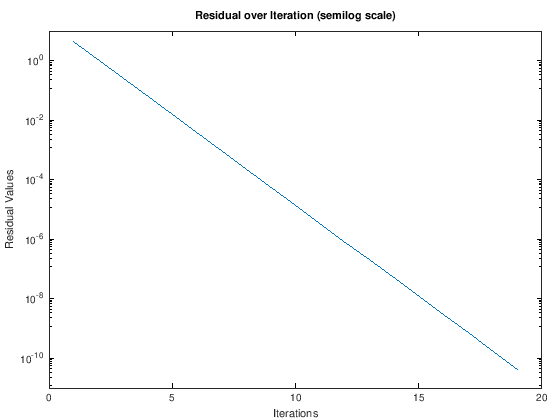

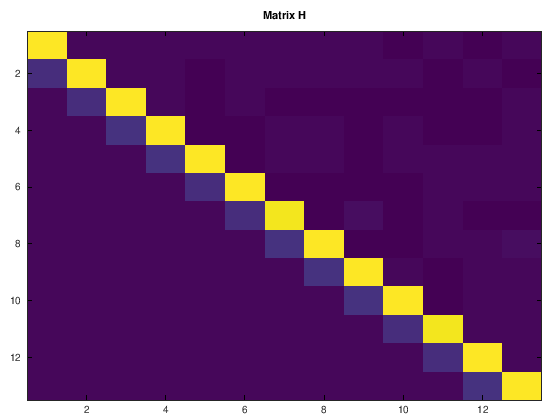

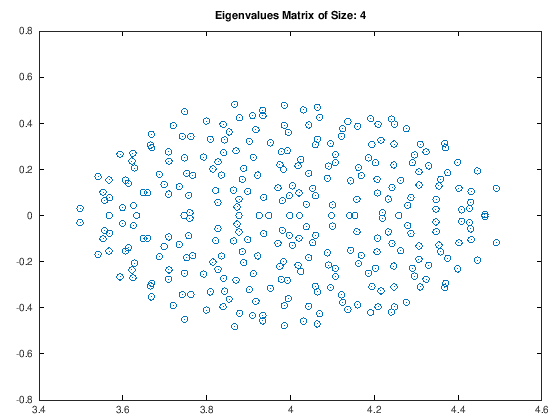

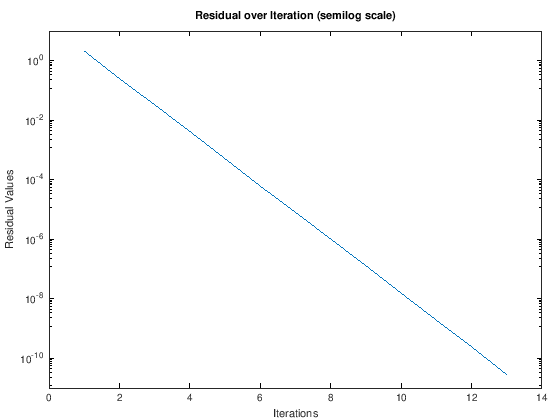

In [22]:
for n = [-4 -2 0 2 4]
%     printf("🍌 n = %d\n", n)
    
    [A, b, x0] = generateData2(300, n=n);
    [x, res] = mygmres(A, b, x0, 150, 1e-10);
    
    x_true = A\b;
    approx_error = norm(x_true-x, 2)
    
    plotEig(A, figTitle=["Eigenvalues Matrix of Size: " num2str(n)]);
    plotResiduals(res);
end

🚀 Raggiunta Tolleranza, stop


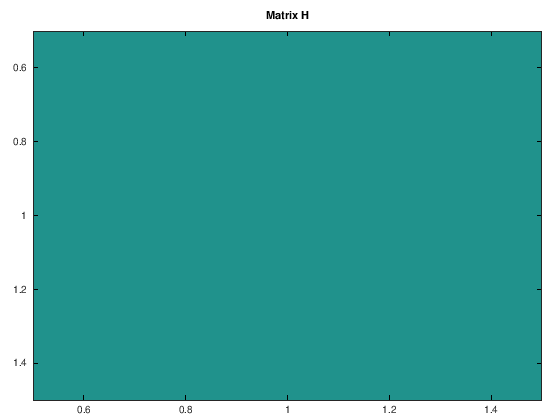

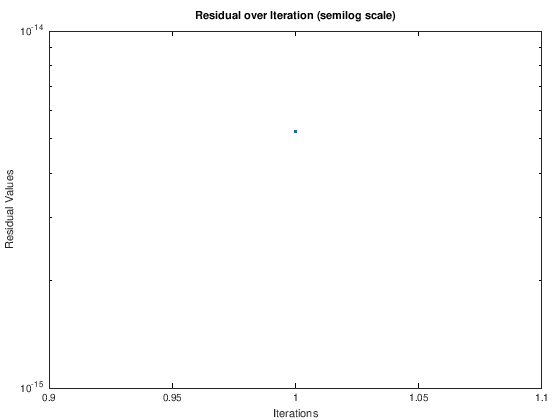

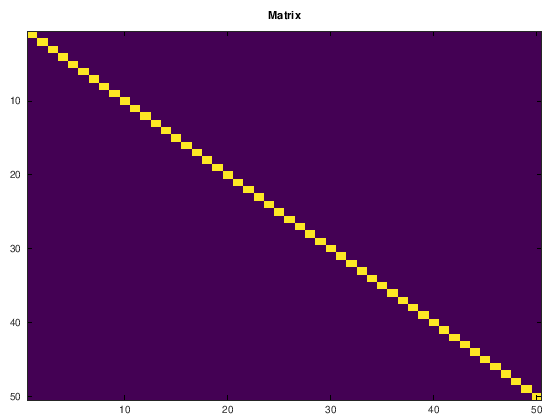

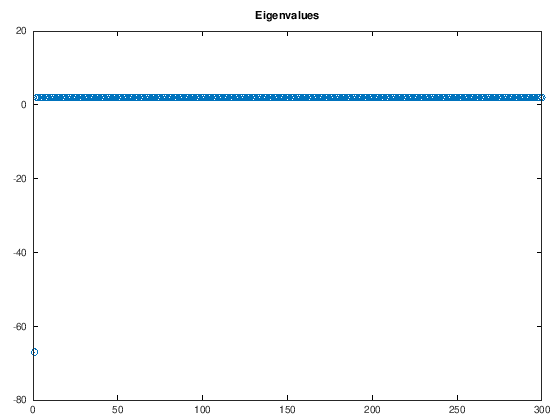

In [23]:
A = (zeros(300)-0.23) + eye(300)*2;
[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);

matrixInfo(A);

## Big Data

Provo a generare una matrice di modeste dimensioni e vedere il tempo di esecuzione di GMRES.

In [30]:
%%time
[A, b, x0] = generateData(10000, .5);

🐌 Raggiunto massimo numero di Iterazioni


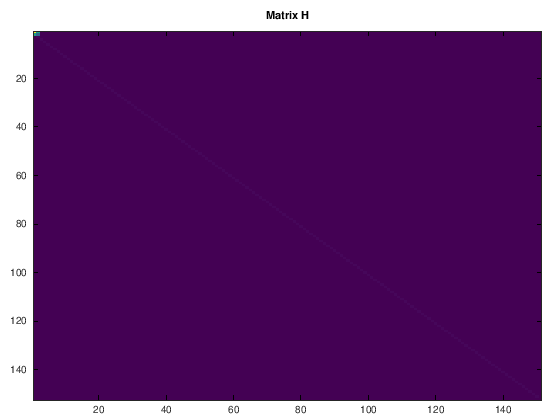

Time: 21.308188676834106 seconds.



In [31]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);

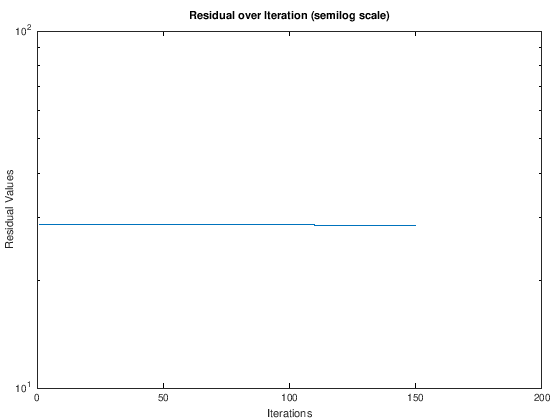

In [32]:
plotResiduals(res);

Provo a generare una matrice di grandi dimensioni che sicuramente permette a GMRES di convergere ma porbabilmente, data l'implementazione di `generateData2()`, non entrerà in memoria.

error: out of memory or dimension too large for Octave's index type
error: called from
    normrnd at line 87 column 11
    generateData2 at line 5 column 7
🐌 Raggiunto massimo numero di Iterazioni


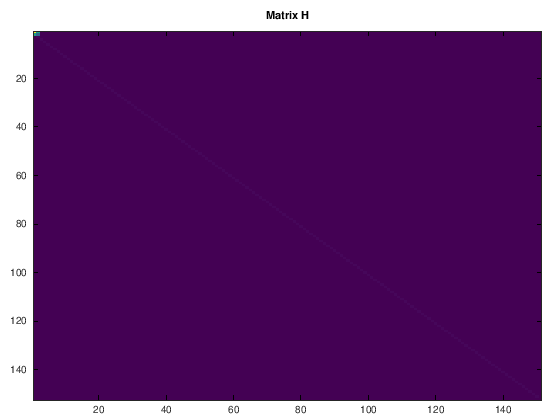

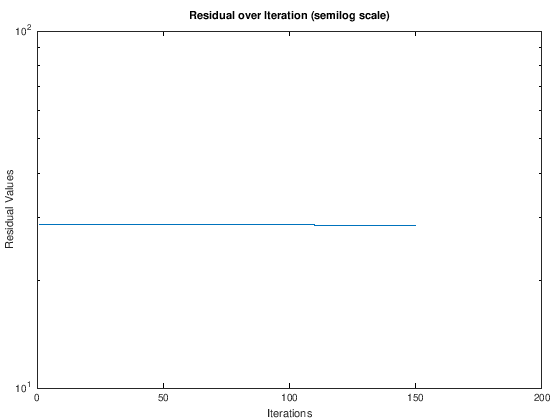

Time: 21.21574378013611 seconds.



In [33]:
[A, b, x0] = generateData2(100000, n=4);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
plotResiduals(res);

Genero una matrice di grandi dimensioni che sicuramente non permette a GMRES di entrare in memoria. Questa volta la matrice `A` è sparsa e, con il giusto valore di _densità_ riesco ad allocarla e lavorarci.

In [34]:
%%time
[A, b, x0] = generateData(100000, .1);

🐌 Raggiunto massimo numero di Iterazioni


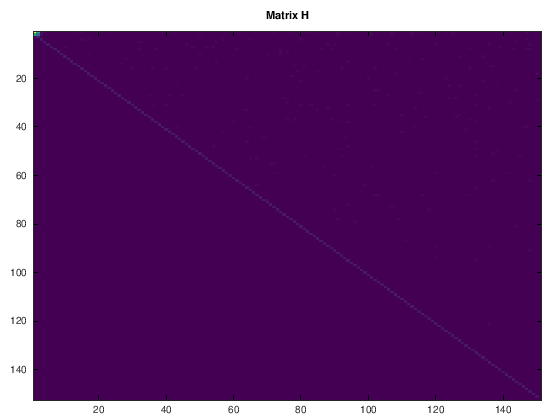

Time: 31.610414505004883 seconds.



In [35]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);

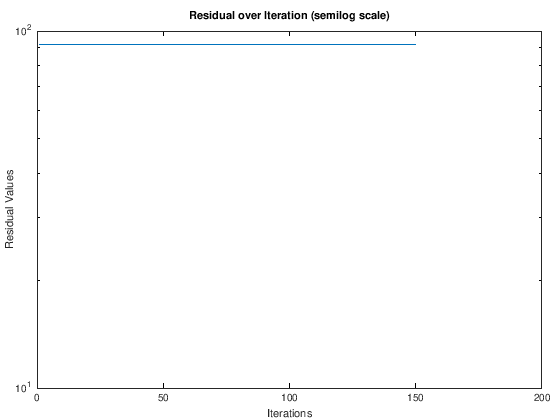

In [36]:
plotResiduals(res);

Definisco una funzione che sia in grado di generare matrici sparse che permettano a GMRES di convergere.

In [37]:
function [A b x0] = generateData3(dim, dense, n=-4, seed=69, randx0=false)
    rand("seed", seed);

    A = sprandn(dim, dim, dense)*0.01 + speye(dim)*n ;

    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

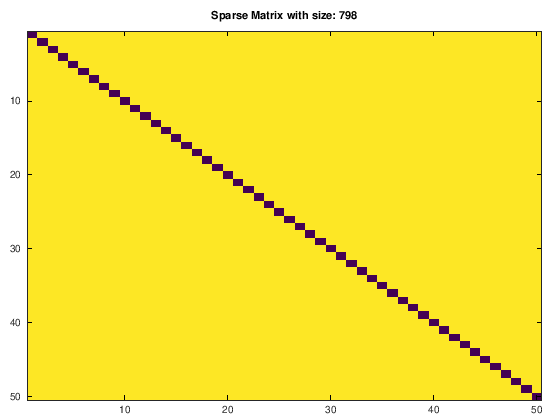

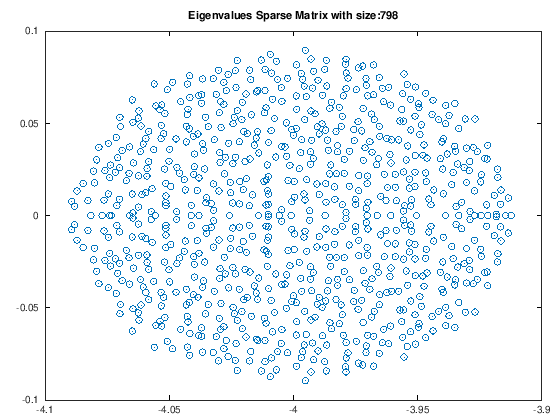

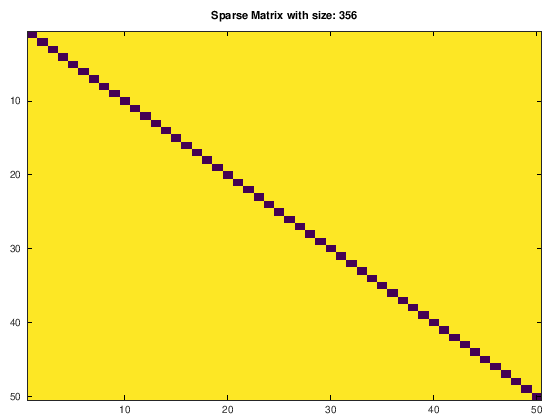

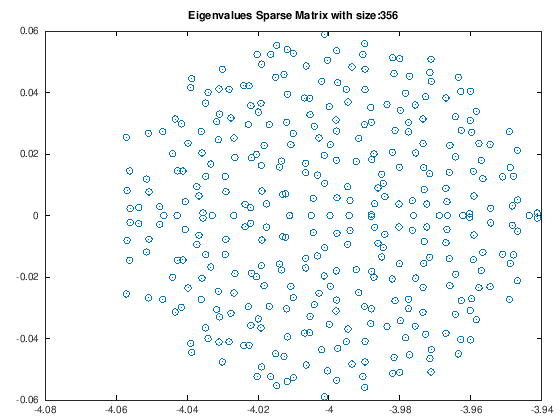

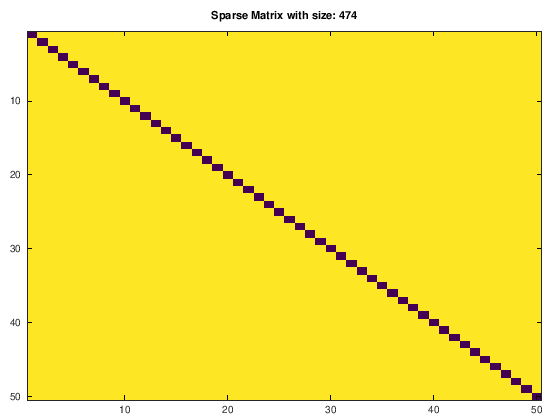

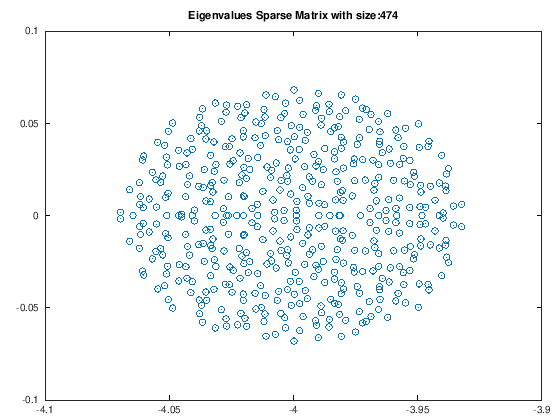

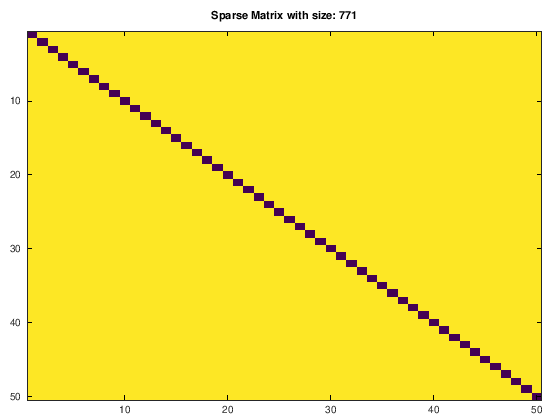

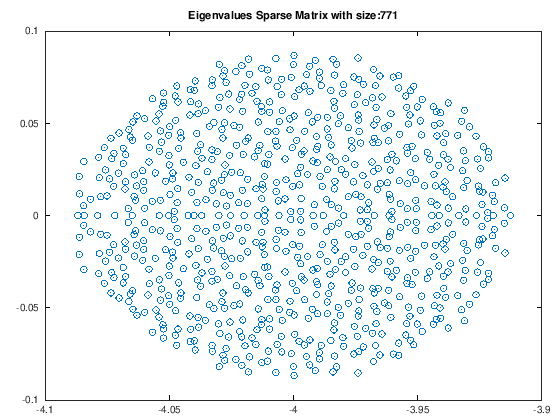

In [38]:
for _ = 1:4
    dim = randi([50 800], 1, 1);

[A b x0] = generateData3(dim, .1);
    
    matrixInfo(
        A, 
        title1=["Sparse Matrix with size: " num2str(dim)],
        title2=["Eigenvalues Sparse Matrix with size:" num2str(dim)]
    );
end

In [39]:
%%time
[A b x0] = generateData3(100000, .1);

Time: 146.6969826221466 seconds.



ans =

   100000   100000

🚀 Raggiunta Tolleranza, stop


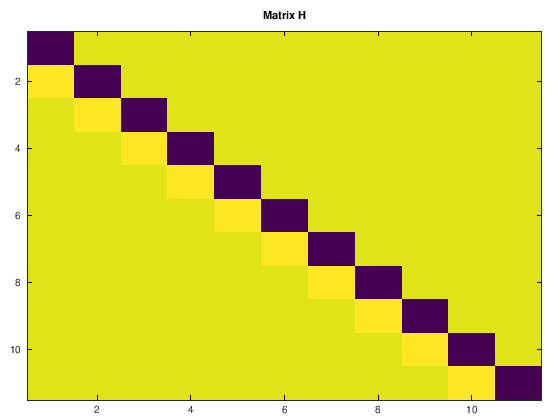

Time: 2.3716518878936768 seconds.



In [40]:
%%time
size(A)
[x, res] = mygmres(A, b, x0, 150, 1e-10);

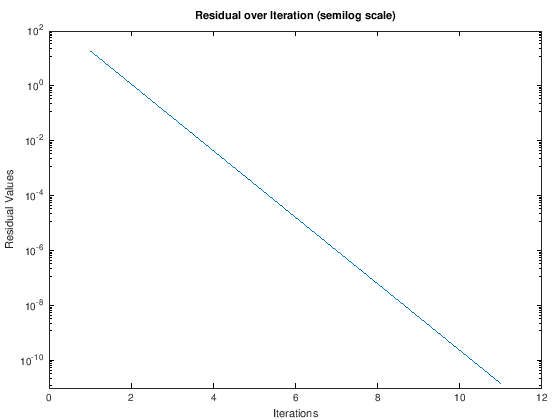

In [41]:
plotResiduals(res);

## GMRES(m)

Implementazion di GMRES con Restarting e vari test.

In [33]:
function [x res] = myrgmres(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;

    while (restartCount < m)
        H = zeros(k+2, k+1);
        Q = zeros(n, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k
            v = A*Q(:, j);  

            % ortogonalizzazione
            for _ = 1:2
                for i = 1:j
                    %H(i,j) = Q(:,i)' * v;
                    tmp = Q(:,i)' * v;
                    v = v - tmp * Q(:, i);
                    H(i,j) += tmp;
                end
            end

            % ortogonalizzazione ??
            %v = mgorth(v, Q); %% è quella bella
    %         v = gramschmidt(v);

            H(j+1, j) = norm(v, 2);

            % TODO: capire come gestire la divisone per 0
            if (H(j+1, j) == 0)
                error("Divisione per 0 !!");
            end

            Q(:, j+1) = v / H(j+1, j);

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H(1:j, 1:j));
                return;
            end
        end
        
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
        restartCount = restartCount + 1;
        
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

🚀 Raggiunta Tolleranza, stop


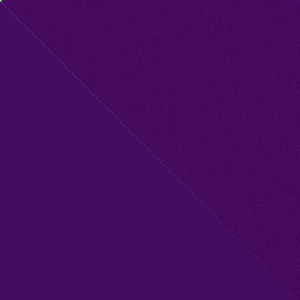

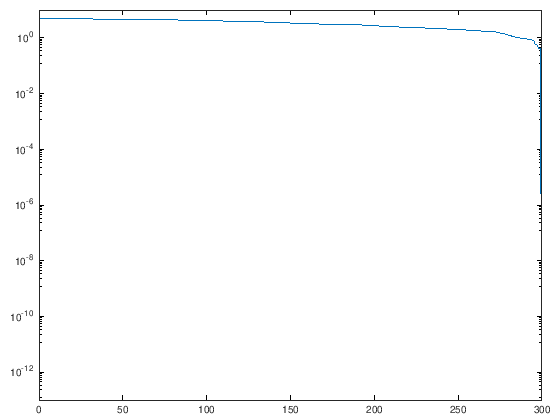

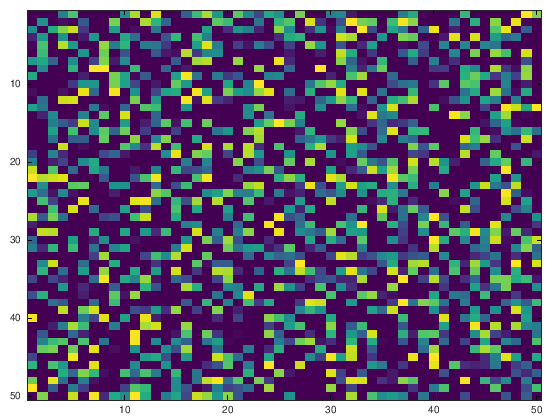

In [40]:
[A, b, x0] = generateData(9000, .5);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop
ans =    1.3054e-09


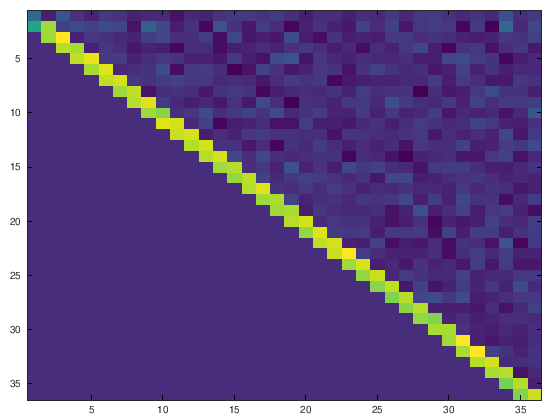

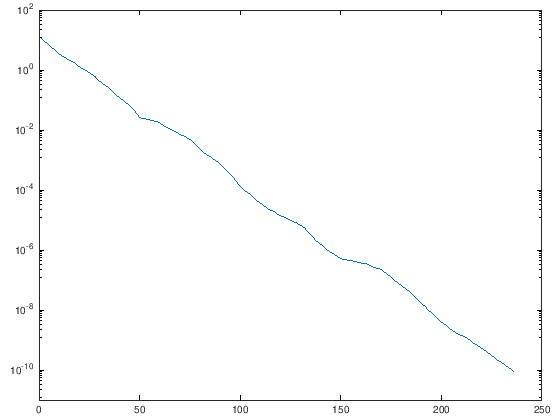

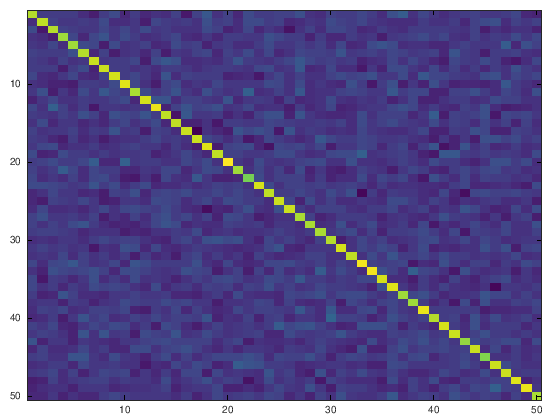

In [55]:
%questo è gustoso 🚀
[A, b, x0] = generateData2(300, .5);
figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
❌ Raggiunto massimo numero di Restart
ans =  68.967


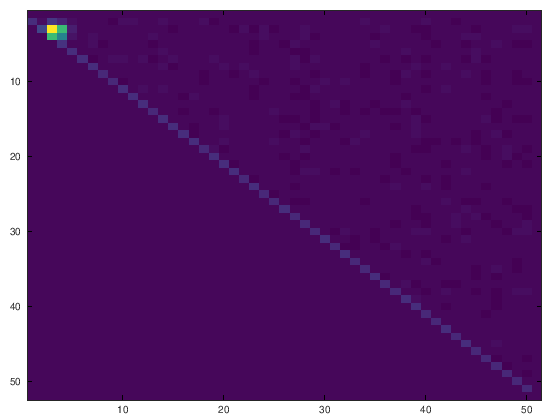

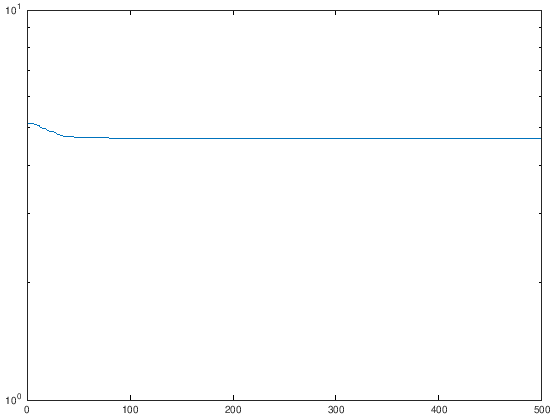

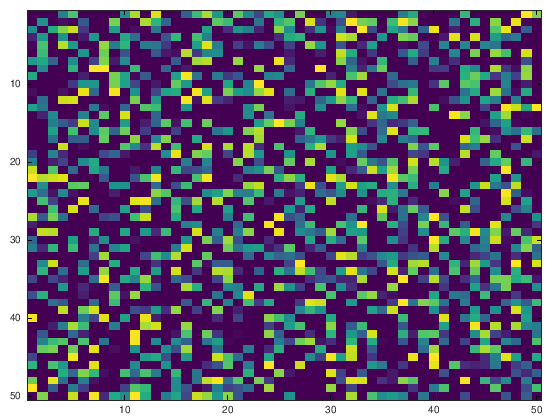

In [41]:
[A, b, x0] = generateData(300, .5);

figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

In [57]:
x_true = A\b;
norm(x_true-x, 2)

ans =  295.03


🚀 Raggiunta Tolleranza, stop
ans =    1.2095e-11


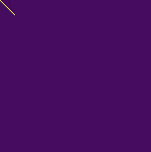

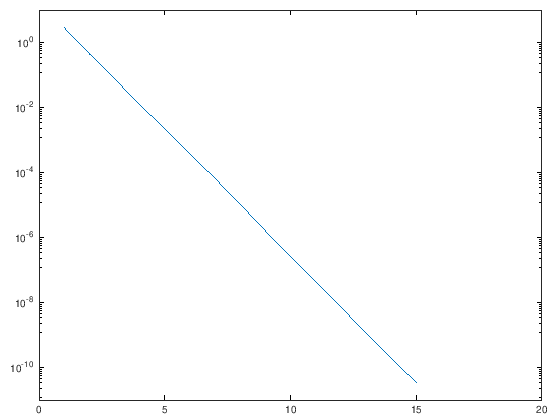

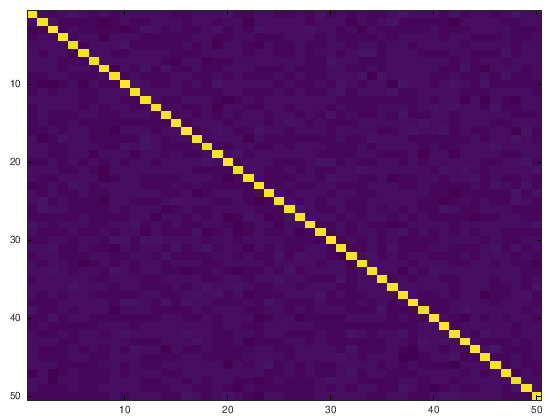

In [59]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🚀 Raggiunta Tolleranza, stop
ans =  1.1308


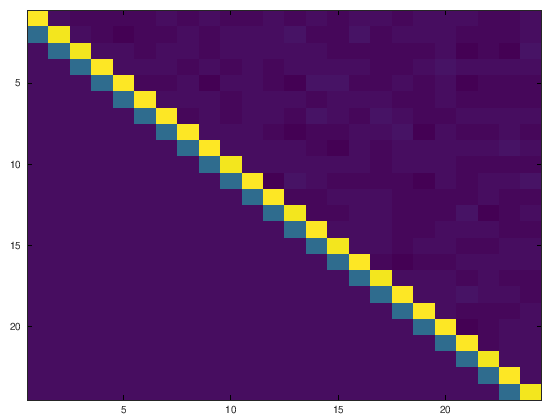

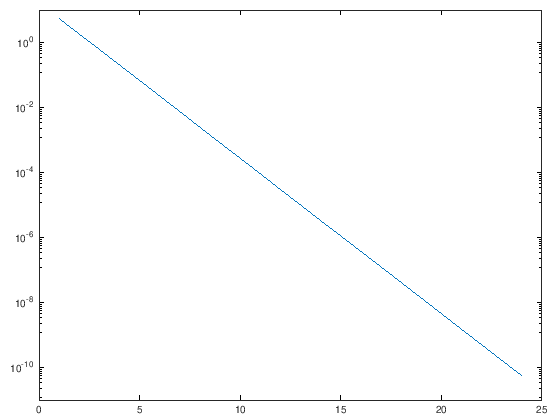

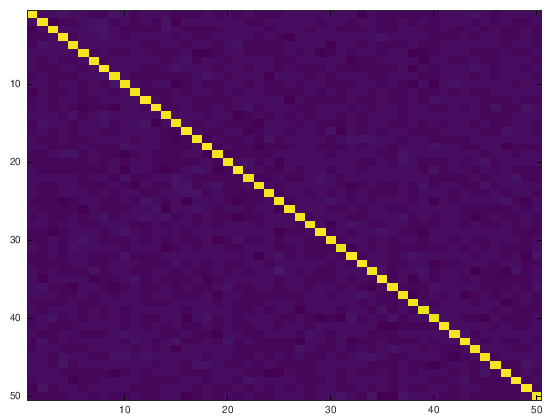

In [58]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


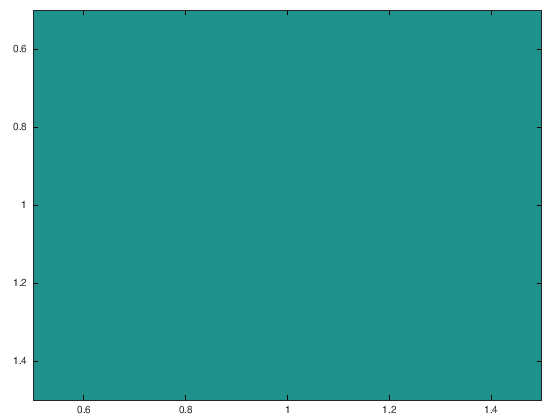

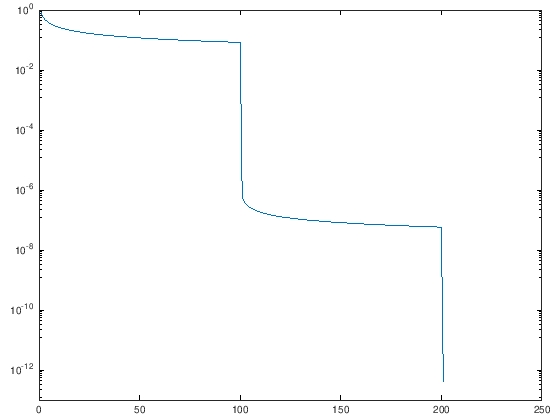

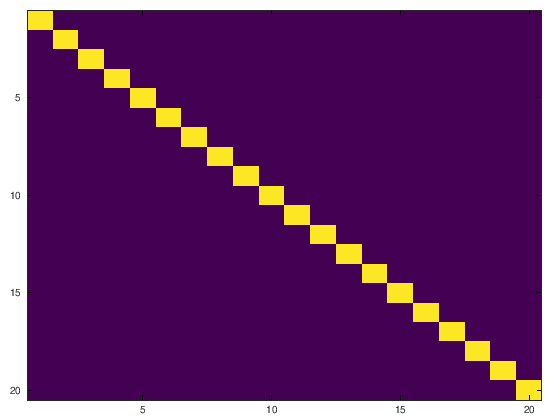

In [17]:
A = eye(10000)*120;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


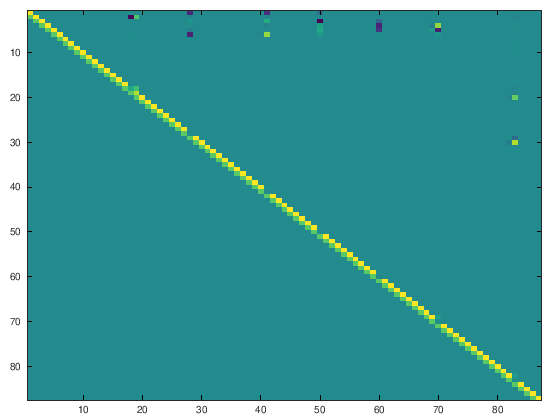

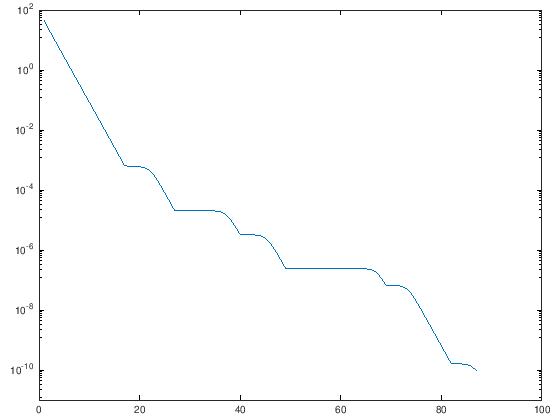

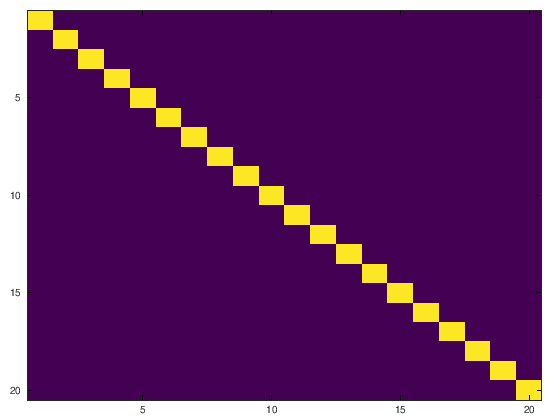

In [18]:
A = (ones(10000)-0.999999999999) + eye(10000)*2;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


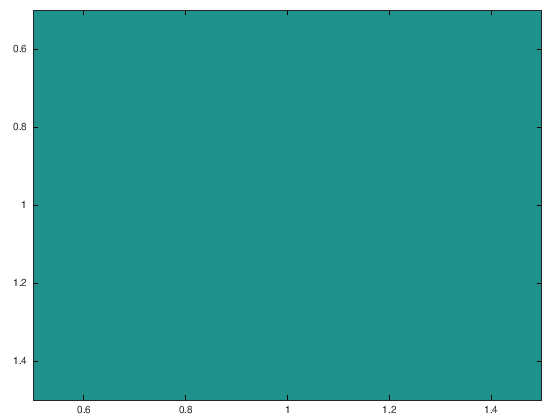

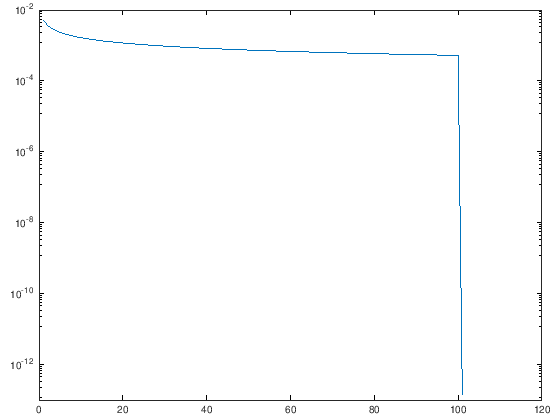

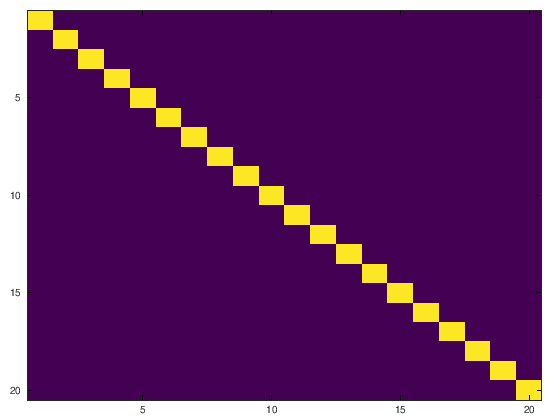

In [19]:
A = (ones(10000)+.9) + eye(10000)*3;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10354
normm =  1.8805
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.41524
normm =  4.1312
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo nume

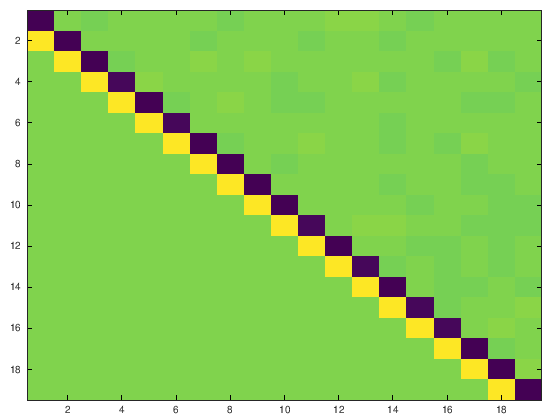

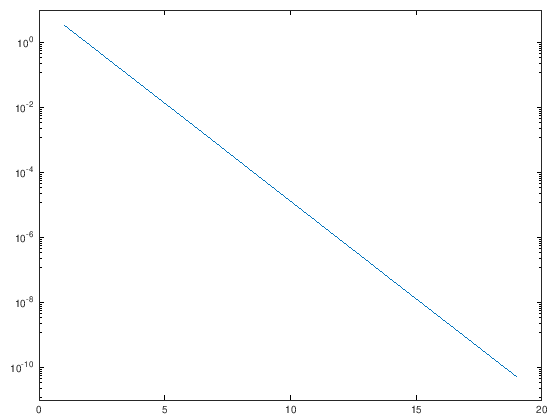

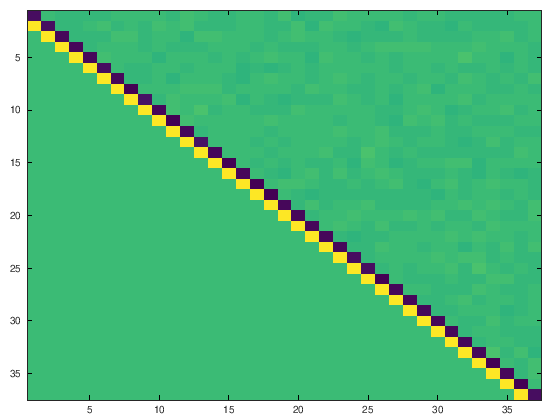

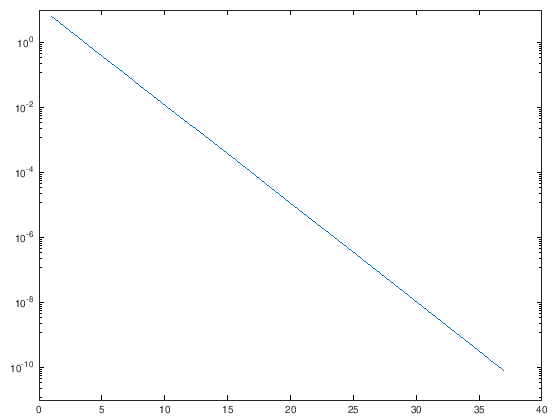

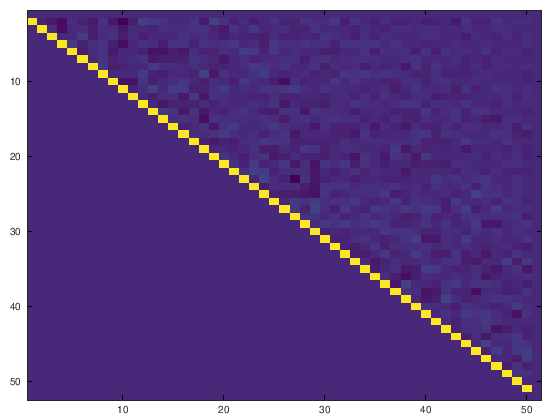

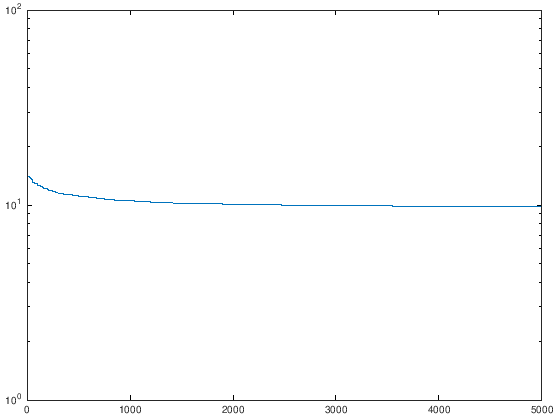

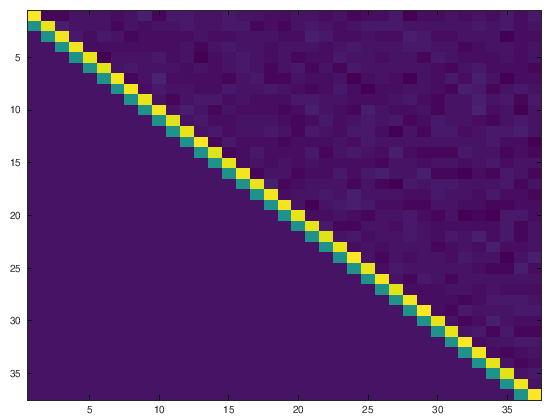

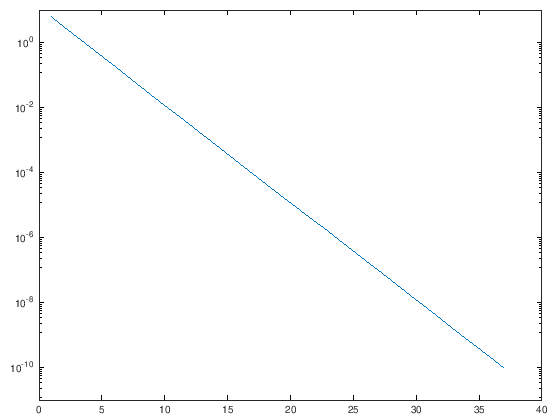

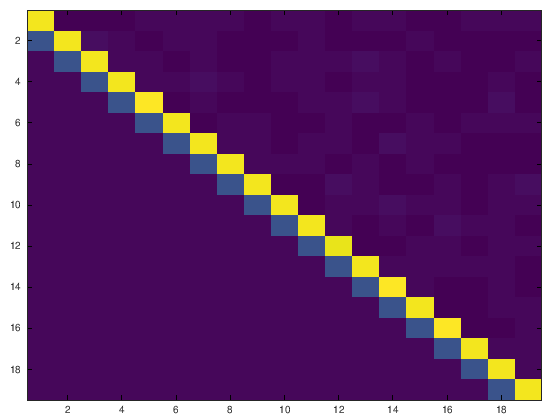

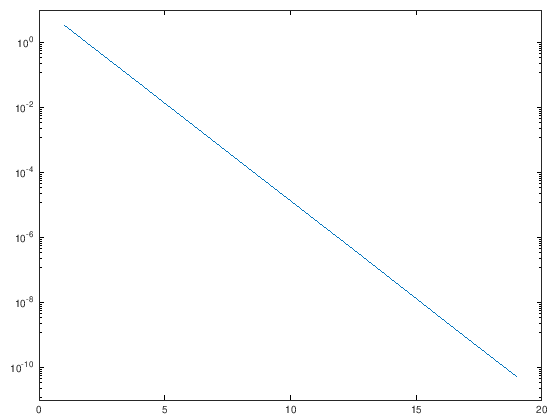

In [20]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end